In [1]:
import numpy as np
import matplotlib.pyplot as plt
import os
import pandas as pd
import netCDF4 as nc
import xarray as xr
import datetime as dt
from salishsea_tools import evaltools as et, viz_tools, places
import gsw 
import matplotlib.gridspec as gridspec
import matplotlib as mpl
import matplotlib.dates as mdates
import cmocean as cmo
import scipy.interpolate as sinterp
import math
from scipy import io
import pickle
import cmocean
from salishsea_tools import Keegan_eval_tools as ket
import json
from collections import OrderedDict
from matplotlib.colors import LogNorm
import arrow
import glob
import datetime
from matplotlib.ticker import (AutoMinorLocator, MultipleLocator)
from matplotlib.dates import HourLocator, MonthLocator, YearLocator

fs=12
mpl.rc('xtick', labelsize=fs)
mpl.rc('ytick', labelsize=fs)
mpl.rc('legend', fontsize=fs)
mpl.rc('axes', titlesize=fs)
mpl.rc('axes', labelsize=fs)
mpl.rc('figure', titlesize=fs)
mpl.rc('font', size=fs)
mpl.rc('font', family='sans-serif', weight='normal', style='normal')

import warnings
#warnings.filterwarnings('ignore')
from IPython.display import Markdown, display

%matplotlib inline

In [2]:
mesh= nc.Dataset('/ocean/ksuchy/MOAD/NEMO-forcing/grid/mesh_mask202108.nc')

In [3]:
mesh

<class 'netCDF4._netCDF4.Dataset'>
root group (NETCDF4 data model, file format HDF5):
    file_name: grid/mesh_mask202108.nc
    TimeStamp: 07/08/2021 17:25:49 -0700
    Conventions: CF-1.6
    title: SalishSeaCast NEMO bathymetry_202108 Bathymetry Mesh Mask
    institution: Dept of Earth, Ocean & Atmospheric Sciences, University of British Columbia
    source: NEMO-3.6 SalishSeaCast configuration
    references: https://github.com/SalishSeaCast/tools/blob/main/bathymetry/Process202108Bathymetry.ipynb
    history: [2021-08-07 17:25] ncks -4 -L4 -O mesh_mask.nc mesh_mask202108.nc
[2023-12-19 13:36] Added metadata to variables in preparation for creation of ERDDAP datasets.
    dimensions(sizes): t(1), y(898), x(398), z(40)
    variables(dimensions): float32 nav_lon(y, x), float32 nav_lat(y, x), float64 time_counter(t), int8 tmask(t, z, y, x), int8 umask(t, z, y, x), int8 vmask(t, z, y, x), int8 fmask(t, z, y, x), int8 tmaskutil(t, y, x), int8 umaskutil(t, y, x), int8 vmaskutil(t, y, x),

In [4]:
with nc.Dataset('/ocean/ksuchy/MOAD/NEMO-forcing/grid/mesh_mask202108.nc') as mesh:
    e3t_1 = np.copy(mesh.variables['e3t_0'][0,0:10,:,:])
    tmask1=np.copy(mesh.variables['tmask'][0,0:10,:,:])
    
    e3t_2 = np.copy(mesh.variables['e3t_0'][0,0:23,:,:])
    tmask2=np.copy(mesh.variables['tmask'][0,0:23,:,:])
    
    e3t_3 = np.copy(mesh.variables['e3t_0'][0,:,:,:])
    tmask3=np.copy(mesh.variables['tmask'][0,:,:,:])
    #navlat=np.copy(mesh.variables['nav_lat'][:,:])
    #navlon=np.copy(mesh.variables['nav_lon'][:,:])

In [5]:
np.shape(tmask1)

(10, 898, 398)

In [6]:
np.shape(tmask2)

(23, 898, 398)

## Bring in grid coordinates for slice/box of interest

In [7]:
CentralSoG = [450, 500,250,300]

In [8]:
yearList = [2007,2008,2009,2010,2011,2012,2013,2014,2015,2016,2017,2018,2019,2020,2021,2022] 

data = 'month-avg.202111'
#year = '2014'
month = '01'
file = 'biol'

for year in yearList:
    files=[glob.glob(f'/results2/SalishSea/{data}/SalishSeaCast_1m_{file}_T_*{year}*{month:02d}01_*{year}*{month:02d}??.nc')[0] for year in yearList for month in range(1,13) ]
    

In [9]:
## Gathering metadata but still not opening the files
dsfiles = xr.open_mfdataset(
        files,
        #chunks=chunk_size,
        compat="override",
        coords="minimal",
        data_vars="minimal",
        drop_variables=['ammonium', 'silicon', \
                        'dissolved_organic_nitrogen', \
                        'particulate_organic_nitrogen', 'biogenic_silicon'],
        parallel=True,
        engine='netcdf4'
    )

/home/ksuchy/anaconda3/envs/py311/lib/python3.11/site-packages/dask/core.py:127: RuntimeWarning: invalid value encountered in divide
  return func(*(_execute_task(a, cache) for a in args))
/home/ksuchy/anaconda3/envs/py311/lib/python3.11/site-packages/dask/core.py:127: RuntimeWarning: invalid value encountered in divide
  return func(*(_execute_task(a, cache) for a in args))
/home/ksuchy/anaconda3/envs/py311/lib/python3.11/site-packages/dask/core.py:127: RuntimeWarning: invalid value encountered in divide
  return func(*(_execute_task(a, cache) for a in args))
/home/ksuchy/anaconda3/envs/py311/lib/python3.11/site-packages/dask/core.py:127: RuntimeWarning: invalid value encountered in divide
  return func(*(_execute_task(a, cache) for a in args))
/home/ksuchy/anaconda3/envs/py311/lib/python3.11/site-packages/dask/core.py:127: RuntimeWarning: invalid value encountered in divide
  return func(*(_execute_task(a, cache) for a in args))


In [10]:
## Mask for nitrate 0-50 m depth range
mask1=np.broadcast_to(tmask1[:,CentralSoG[0]:CentralSoG[1], 
                               CentralSoG[2]:CentralSoG[3]],(192,10,50,50)) 

In [11]:
e3t1=np.broadcast_to(e3t_1[:,CentralSoG[0]:CentralSoG[1], 
                               CentralSoG[2]:CentralSoG[3]],(192,10,50,50)) 

In [12]:
## Mask for chlorophyll 0-50 m depth range
mask2=np.broadcast_to(tmask2[:,CentralSoG[0]:CentralSoG[1], 
                               CentralSoG[2]:CentralSoG[3]],(192,23,50,50))

In [13]:
e3t2=np.broadcast_to(e3t_2[:,CentralSoG[0]:CentralSoG[1], 
                               CentralSoG[2]:CentralSoG[3]],(192,23,50,50)) 

In [14]:
## Mask for zooplankton full water column depth range
mask3=np.broadcast_to(tmask3[:,CentralSoG[0]:CentralSoG[1], 
                               CentralSoG[2]:CentralSoG[3]],(192,40,50,50))

In [15]:
e3t3=np.broadcast_to(e3t_3[:,CentralSoG[0]:CentralSoG[1], 
                               CentralSoG[2]:CentralSoG[3]],(192,40,50,50)) 

In [16]:
## Time and depth files
tt=np.array(dsfiles.time)
mod_depth=np.array(dsfiles.depth)

### Nitrate

In [17]:
mod_nitrate=(dsfiles.nitrate[:,0:10, CentralSoG[0]:CentralSoG[1], 
                               CentralSoG[2]:CentralSoG[3]])

e3t1 = xr.DataArray(e3t1, dims=mod_nitrate.dims, coords=mod_nitrate.coords)

mod_nitrate = (((mod_nitrate * e3t1)
                 .where(mask1 ==1) 
                 .sum(dim='depth')
                )                       
                /e3t1.where(mask1==1).sum(dim='depth')
               ).compute()

#mod_nitrate_mean = ((((mod_nitrate * e3t1).where(mask1 ==1).sum(dim='depth'))
#                                           /e3t1.where(mask1==1).sum(dim='depth')
#                                            ).mean(dim='gridX').mean(dim='gridY'))

#mod_nitrate_std = ((((mod_nitrate * e3t1).where(mask1 ==1).sum(dim='depth'))
#                                           /e3t1.where(mask1==1).sum(dim='depth')
#                                            ).std(dim='gridX').std(dim='gridY'))

In [18]:
#mod_nitrate=(np.array(mod_nitrate))

In [19]:
mod_nitrate = mod_nitrate.T ## transpose the variable to make it work with the Hovmoller plots

In [20]:
np.shape(mod_nitrate)

(50, 50, 192)

In [21]:
mod_nitrate_mean=np.mean(mod_nitrate, axis=(0, 1)) ## calculate the mean across the entire slice/box 4d to 2d array

In [22]:
mod_nitrate_mean.max() 

<xarray.DataArray ()> Size: 8B
array(23.95593795)

In [23]:
mod_nitrate_mean.min() 

<xarray.DataArray ()> Size: 8B
array(0.)

In [24]:
mod_nitrate_std=np.std(mod_nitrate, axis=(0, 1))

In [25]:
## spatial + temporal varance
mod_nitrate_variance=pd.read_csv('/home/sallen/MEOPAR/ANALYSIS/analysis-susan/notebooks/Karyn/CSOG_nitrate_2007_2022.csv')

In [26]:
#mod_nitrate_variance

In [27]:
mod_nitrate_std_new=np.sqrt(mod_nitrate_variance['nitrate variance'].to_numpy()) ## need to convert to numpy so that we can subtract from the model masked array

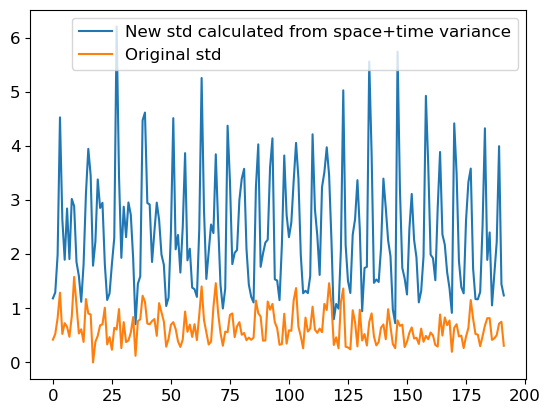

In [28]:
plt.plot(mod_nitrate_std_new,label='New std calculated from space+time variance')
plt.plot(mod_nitrate_std,label='Original std')
plt.legend()

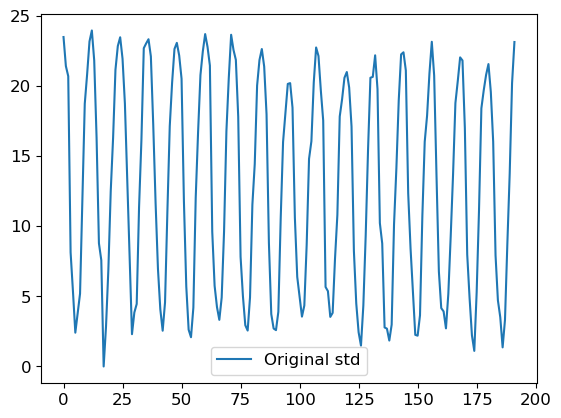

In [29]:
#plt.plot(mod_nitrate_std_new,label='New std calculated from space+time variance')
plt.plot(mod_nitrate_mean,label='Original std')
plt.legend()

In [30]:
mod_nitrate_mean_clean=mod_nitrate_mean.where((mod_nitrate_mean != 0) & np.isfinite(mod_nitrate_mean), drop=False)

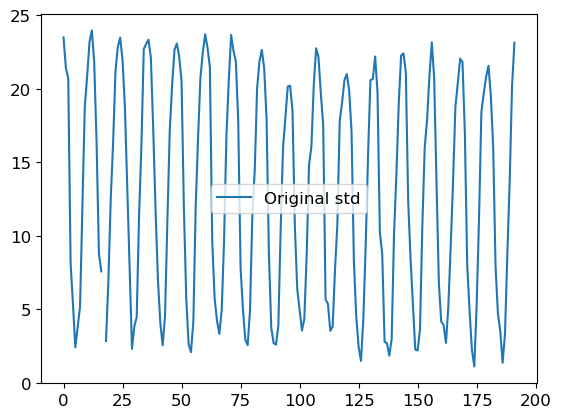

In [31]:
plt.plot(mod_nitrate_mean_clean,label='Original std')
plt.legend()

### Chlorophyll a

In [32]:
mod_diatoms=(dsfiles.diatoms[:,0:23, CentralSoG[0]:CentralSoG[1], ### choose for 5 m only
                               CentralSoG[2]:CentralSoG[3]])

e3t2 = xr.DataArray(e3t2, dims=mod_diatoms.dims, coords=mod_diatoms.coords)

#mod_diatoms = (np.array(mod_diatoms))

mod_diatoms = (((mod_diatoms * e3t2)
                 .where(mask2 ==1)
                 .sum(dim='depth')
                )                       
                /e3t2.where(mask2==1).sum(dim='depth')
               ).compute() ## masking where there is land

mod_flag=(dsfiles.flagellates[:,0:23, CentralSoG[0]:CentralSoG[1], ### choose for 5 m only
                               CentralSoG[2]:CentralSoG[3]])
#mod_flag = (np.array(mod_flag))

mod_flag = (((mod_flag * e3t2)
                 .where(mask2 ==1)
                 .sum(dim='depth')
                )                       
                /e3t2.where(mask2==1).sum(dim='depth')
               ).compute() ## masking where there is land

In [33]:
mod_diatoms = mod_diatoms.T ## transpose the variable to make it work with the Hovmoller plots

In [34]:
mod_flag = mod_flag.T

In [35]:
np.shape(mod_diatoms)

(50, 50, 192)

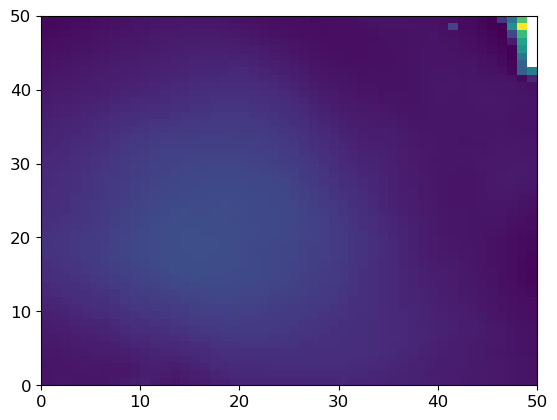

In [36]:
## Check to see what is there

plt.pcolormesh(mod_diatoms[:,:,0]) ## viewing the first depth at the first time stamp; remember z and t are the last two axes here


In [37]:
mod_chl=(mod_diatoms+mod_flag)*2 ##Chl:N ratio of 2.0

In [38]:
mod_chl_mean=np.mean(mod_chl, axis=(0, 1)) ## calculate the mean across the entire slice/box 4d to 2d array and entire depth range

In [39]:
mod_chl_std=np.std(mod_chl, axis=(0, 1))

In [40]:
## spatial + temporal varance
mod_chl_variance=pd.read_csv('/home/sallen/MEOPAR/ANALYSIS/analysis-susan/notebooks/Karyn/CSOG_phyto_2007_2022.csv')

In [41]:
mod_chl_variance

,Unnamed: 0,Year,Month,diatoms variance,flagellates variance,diatoms variance time,diatoms variance space,flagellates variance time,flagellates variance space
0,0,2007,1,0.001015,0.000203,0.000639,0.000091,0.000077,0.000032
1,1,2007,2,0.001674,0.000287,0.001046,0.000177,0.000186,0.000022
2,2,2007,3,0.015093,0.000214,0.011647,0.000902,0.000072,0.000041
3,3,2007,4,0.148518,0.000420,0.101784,0.010534,0.000364,0.000012
4,4,2007,5,0.058579,0.002078,0.024727,0.006508,0.001508,0.000151
...,...,...,...,...,...,...,...,...,...
187,187,2022,8,0.000696,0.009596,0.000284,0.000056,0.005969,0.001292
188,188,2022,9,0.002972,0.001454,0.001738,0.000363,0.001127,0.000120
189,189,2022,10,0.003427,0.000244,0.002383,0.000345,0.000157,0.000016
190,190,2022,11,0.000825,0.000264,0.000443,0.000112,0.000098,0.000032


In [42]:
mod_chl_std_new=(np.sqrt(mod_chl_variance['diatoms variance'].to_numpy()) \
                  + np.sqrt(mod_chl_variance['flagellates variance'].to_numpy()))*2

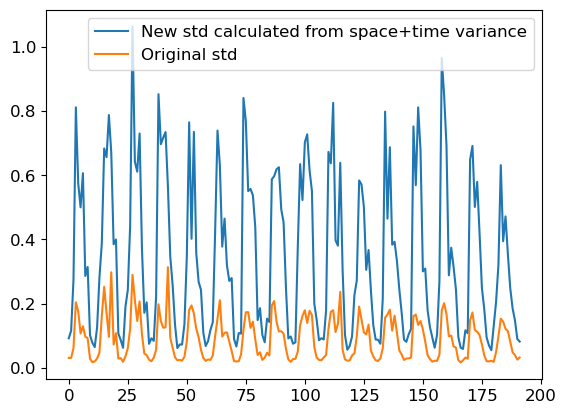

In [43]:
plt.plot(mod_chl_std_new,label='New std calculated from space+time variance')
plt.plot(mod_chl_std,label='Original std')
plt.legend()

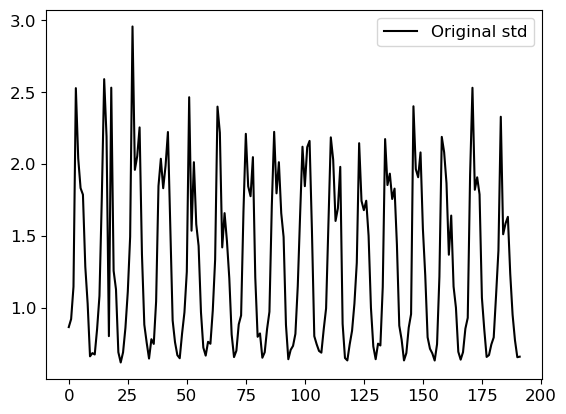

In [44]:
plt.plot(mod_chl_mean,label='Original std',color='k')
plt.legend()

In [45]:
mod_chl_mean

<xarray.DataArray (time: 192)> Size: 2kB
array([0.86606347, 0.92190257, 1.14682662, 2.52902346, 2.04056284,
       1.83328718, 1.78788015, 1.28651877, 1.02824691, 0.6625709 ,
       0.68498342, 0.6754305 , 0.85280084, 1.08302719, 1.76802015,
       2.59152921, 2.19245647, 0.80298691, 2.53221556, 1.25765005,
       1.1290952 , 0.69135228, 0.61974571, 0.69058689, 0.8604483 ,
       1.11161768, 1.4950056 , 2.95811723, 1.96047663, 2.05649751,
       2.2558396 , 1.37295928, 0.88274301, 0.75815389, 0.6471152 ,
       0.78164027, 0.74894075, 1.04443351, 1.84771533, 2.03753588,
       1.83244699, 1.98891783, 2.22366426, 1.56449437, 0.91260346,
       0.76122683, 0.67054714, 0.64920338, 0.82172489, 0.96905712,
       1.25137157, 2.46576878, 1.53689662, 2.01362827, 1.5818124 ,
       1.43054198, 0.96891326, 0.72342854, 0.66746984, 0.7635225 ,
       0.75004684, 0.98147361, 1.33607114, 2.40034445, 2.21850198,
       1.42055476, 1.65912396, 1.46426152, 1.20532255, 0.814158  ,
       0.65730165, 0.70182355, 0.88509124, 0.94747638, 1.67059976,
       2.21111298, 1.84582399, 1.77693249, 2.04878965, 1.21204801,
       0.79855932, 0.82192915, 0.65266085, 0.69102538, 0.85266223,
       0.97279731, 1.70703869, 2.22476005, 1.79688903, 2.01364695,
       1.65877891, 1.49306325, 0.88151837, 0.64248648, 0.70754949,
       0.73534892, 0.81892258, 1.15109798, 1.64931502, 2.12127925,
       1.84664757, 2.11808093, 2.16187361, 1.54049142, 0.80273329,
       0.74689174, 0.70014072, 0.68814727, 0.85159056, 0.99671248,
       1.60482169, 2.18647252, 2.03100634, 1.60471617, 1.69331206,
       1.98120958, 0.88863122, 0.65087238, 0.63405637, 0.74621438,
       0.84070164, 1.02959997, 1.31326057, 2.14582282, 1.74409856,
       1.67979889, 1.74539827, 1.50155496, 0.99968563, 0.73155152,
       0.64256773, 0.75069608, 0.73807031, 1.1452318 , 2.17445503,
       1.85470552, 1.93385732, 1.75765426, 1.82964286, 1.439285  ,
       0.87603267, 0.77800625, 0.63393167, 0.68551557, 0.86199845,
       0.95651044, 2.40280263, 1.96567317, 1.9088101 , 2.08164243,
       1.55100119, 1.2263998 , 0.79510721, 0.71533754, 0.68309067,
       0.63335228, 0.74720639, 1.21779071, 2.18979514, 2.08342065,
       1.86765485, 1.3695549 , 1.64213833, 1.14803777, 1.00118052,
       0.69432541, 0.63941651, 0.69156712, 0.85524798, 0.93021278,
       1.92602605, 2.53152292, 1.82165702, 1.90826112, 1.78991057,
       1.07033537, 0.8498867 , 0.65838732, 0.67130875, 0.74528208,
       0.79402833, 1.08690874, 1.3985303 , 2.32985341, 1.51203199,
       1.58684713, 1.63335919, 1.23723907, 0.9517494 , 0.7752928 ,
       0.65633879, 0.66006376])
Coordinates:
  * time     (time) datetime64[ns] 2kB 2007-01-15T12:00:00 ... 2022-12-15T12:...

In [46]:
mod_chl_mean_clean=mod_chl_mean.where((mod_chl_mean != 0) & np.isfinite(mod_nitrate_mean), drop=False)

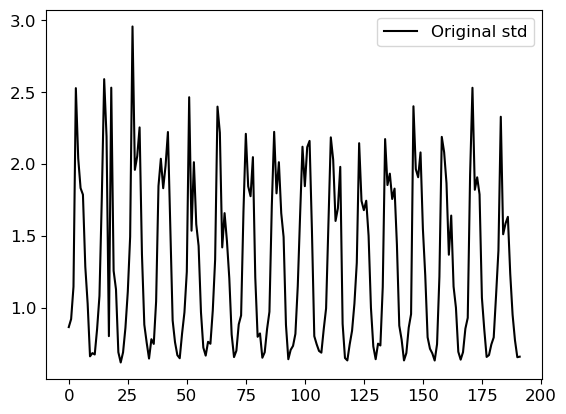

In [47]:
plt.plot(mod_chl_mean_clean,label='Original std',color='k')
plt.legend()

### Zooplankton

In [48]:
mod_microzooplankton=(dsfiles.microzooplankton[:,:, CentralSoG[0]:CentralSoG[1], ### choose for 5 m only
                               CentralSoG[2]:CentralSoG[3]])

e3t3 = xr.DataArray(e3t3, dims=mod_microzooplankton.dims, coords=mod_microzooplankton.coords)

#mod_microzooplankton = (np.array(mod_microzooplankton))

mod_microzooplankton = (((mod_microzooplankton * e3t3)
                 .where(mask3 ==1)
                 .sum(dim='depth')
                )                       
                /e3t3.where(mask3==1).sum(dim='depth')
               ).compute() ## masking where there is land

mod_mesozooplankton=(dsfiles.mesozooplankton[:,:, CentralSoG[0]:CentralSoG[1], ### choose for 5 m only
                               CentralSoG[2]:CentralSoG[3]])
#mod_mesozooplankton = (np.array(mod_microzooplankton))

mod_mesozooplankton =(((mod_mesozooplankton * e3t3)
                 .where(mask3 ==1)
                 .sum(dim='depth')
                )                       
                /e3t3.where(mask3==1).sum(dim='depth')
               ).compute() ## masking where there is land

In [49]:
mod_microzooplankton = mod_microzooplankton.T ## transpose the variable to make it work with the Hovmoller plots

In [50]:
mod_mesozooplankton = mod_mesozooplankton.T

In [51]:
np.shape(mod_microzooplankton)

(50, 50, 192)

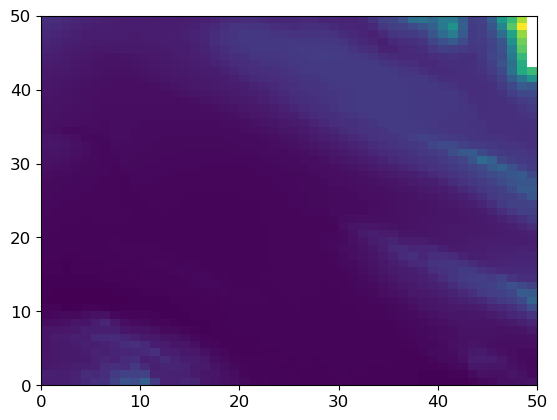

In [52]:
## Check to see what is there

plt.pcolormesh(mod_microzooplankton[:,:,0]) ## viewing the first depth at the first time stamp; remember z and t are the last two axes here


In [53]:
mod_zoop=(mod_microzooplankton+mod_mesozooplankton)*5.7*12 ## C:N ratio for zooplankton

In [54]:
mod_zoop_mean=np.mean(mod_zoop, axis=(0, 1)) ## calculate the mean across the entire slice/box 4d to 2d array and entire depth range

In [55]:
mod_zoop_std=np.std(mod_zoop, axis=(0, 1))

In [56]:
## spatial + temporal varance
mod_zoop_variance=pd.read_csv('/home/sallen/MEOPAR/ANALYSIS/analysis-susan/notebooks/Karyn/CSOG_zoo_2007_2022.csv')


In [57]:
mod_zoop_variance.keys()

Index(['Unnamed: 0', 'Year', 'Month', 'microzooplankton variance',
       'mesozooplankton variance', 'microzooplankton variance time',
       'microzooplankton variance space', 'mesozooplankton variance time',
       'mesozooplankton variance space'],
      dtype='object')

In [58]:
mod_zoop_std_new=(np.sqrt(mod_zoop_variance['microzooplankton variance'].to_numpy()) \
                  + np.sqrt(mod_zoop_variance['mesozooplankton variance'].to_numpy()))*5.7*12

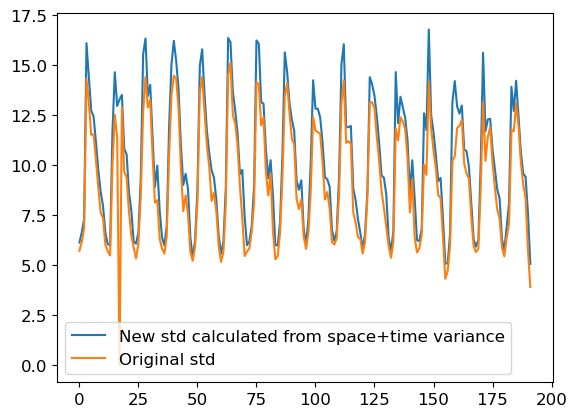

In [59]:
plt.plot(mod_zoop_std_new,label='New std calculated from space+time variance')
plt.plot(mod_zoop_std,label='Original std')
plt.legend()

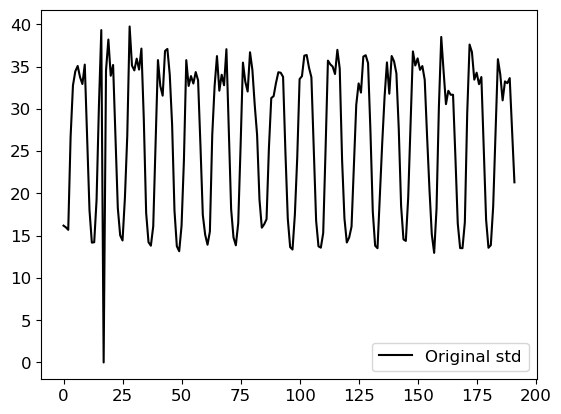

In [60]:
plt.plot(mod_zoop_mean,label='Original std',color='k') ### check data for missing values or zeros
plt.legend()

In [61]:
mod_zoop_mean_clean=mod_zoop_mean.where((mod_zoop_mean != 0) & np.isfinite(mod_zoop_mean), drop=False) ## remove the missing file but don't drop it

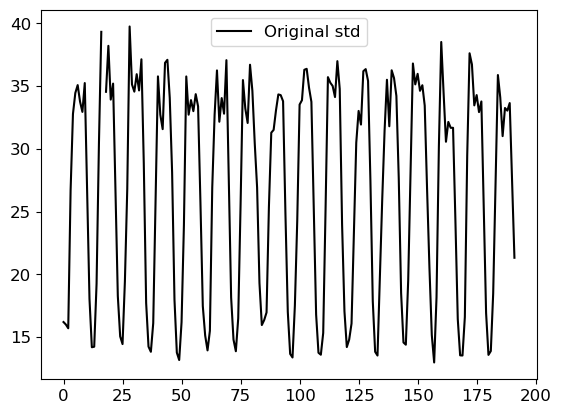

In [62]:
plt.plot(mod_zoop_mean_clean,label='Original std',color='k')
plt.legend()

In [63]:
dsfiles.close()

## Import Observation Data

### Observation nitrate and chlorophyll

In [64]:
data=pd.read_csv('/data/rbeutel/obs/PNW_obs_compiled.csv')

In [65]:
data.keys()

Index(['Unnamed: 0', 'time', 'longitude (degrees_east)',
       'latitude (degrees_north)', 'depth (m)', 'pressure (dbar)',
       'temperature (degC)', 'salinity (g kg-1)', 'DO (umol kg-1)', 'NO3 (uM)',
       'NO2 (uM)', 'NH4 (uM)', 'PO4 (uM)', 'SiO4 (uM)', 'Chl (mg m-3)',
       'TA (uM)', 'DIC (uM)', 'Carbonate', 'Aragonite', 'Calcite',
       'Cd (nmol kg-1)', 'Co (nmol kg-1)', 'Cu (nmol kg-1)', 'Fe (nmol kg-1)',
       'Mn (nmol kg-1)', 'Ni (nmol kg-1)', 'Zn (nmol kg-1)', 'source',
       'Nstar (umol kg-1)', 'spice'],
      dtype='object')

In [66]:
data['time']=pd.to_datetime(data['time']) 

In [67]:
data['time']

0         1930-11-07 00:00:00+00:00
1         1930-11-07 00:00:00+00:00
2         1930-11-07 00:00:00+00:00
3         1930-11-07 00:00:00+00:00
4         1930-11-07 00:00:00+00:00
                     ...           
2340054   2024-11-19 00:00:00+00:00
2340055   2024-11-19 00:00:00+00:00
2340056   2024-11-19 00:00:00+00:00
2340057   2024-11-19 00:00:00+00:00
2340058   2024-11-19 00:00:00+00:00
Name: time, Length: 2340059, dtype: datetime64[ns, UTC]

In [68]:
data['Year']=[ii.year for ii in data['time']]
data['Month']=[ii.month for ii in data['time']]
#data['YD']=et.datetimeToYD(data['time'])

In [69]:
data['YMO']=pd.to_datetime(data[['Year', 'Month']].assign(DAY=1))

In [70]:
data.rename(columns={'longitude (degrees_east)':'Lon','latitude (degrees_north)':'Lat'},inplace=True) 

In [71]:
data=data[~(data['Lat'] <= 49.1) & (data['Lat'] < 49.35) & (data['Lon'] <= -123.3) & (data['Lon'] > -123.75)] 

In [72]:
data=data[(data['Year'] >= 2007) & (data['Year'] <= 2022)]

In [73]:
#data=data[(data['Month'] >= 2) & (data['Month'] <= 10)] ## leave out if using all months

In [74]:
nitrate=data[(data['depth (m)'] <= 10)] ## select depths less than or equal to 10 m
chl=data[(data['depth (m)'] <= 50)] ## select depths less than or equal to 50 m

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


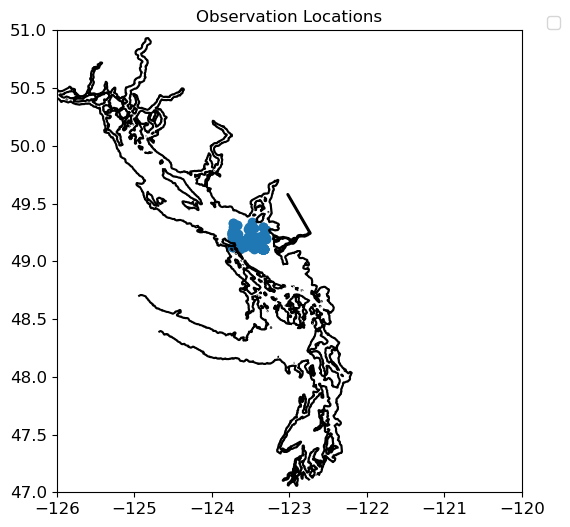

In [75]:
fig, ax = plt.subplots(1,1,figsize = (6,6))
with nc.Dataset('/ocean/ksuchy/MOAD/NEMO-forcing/grid/bathymetry_201702.nc') as grid:
    viz_tools.plot_coastline(ax, grid, coords = 'map',isobath=.1)
colors=('teal','green','firebrick','darkorange','darkviolet','fuchsia',
        'royalblue','darkgoldenrod','mediumspringgreen','deepskyblue','lightblue')
#datreg=dict()
#for ind, iregion in enumerate(data.region_name.unique()):
#    datreg[iregion] = data.loc[data.region_name==iregion]
ax.scatter(nitrate['Lon'], nitrate['Lat'],marker='o') #color = colors[ind]
ax.set_ylim(47,51)
ax.legend(bbox_to_anchor=[1,.6,0,0])
ax.set_xlim(-126, -120);
ax.set_title('Observation Locations');
ax.legend(bbox_to_anchor=(1.1, 1.05))

In [76]:
np.shape(nitrate['NO3 (uM)'])

(367,)

In [77]:

nitrate=nitrate.dropna(subset=['NO3 (uM)'])

In [78]:
obs_nitrate=nitrate.groupby(['time','Lon','Lat','YMO','Year'])['NO3 (uM)'].mean().reset_index()

In [79]:
obs_nitrate_std=nitrate.groupby(['time','Lon','Lat','YMO','Year'])['NO3 (uM)'].std().reset_index()

In [80]:
obs_nitrate_YMO=obs_nitrate.groupby(['YMO','Year'])['NO3 (uM)'].mean().reset_index()

In [81]:
obs_nitrate_YMO_std=obs_nitrate.groupby(['YMO','Year'])['NO3 (uM)'].std().reset_index()

In [82]:
obs_nitrate_YMO

,YMO,Year,NO3 (uM)
0,2007-02-01,2007,26.300000
1,2007-04-01,2007,7.400000
2,2007-06-01,2007,2.950000
3,2007-10-01,2007,21.900000
4,2008-03-01,2008,19.520000
...,...,...,...
85,2021-10-01,2021,16.841667
86,2022-04-01,2022,21.715000
87,2022-05-01,2022,7.480000
88,2022-06-01,2022,0.030000


### Chlorophyll

In [83]:
np.shape(chl['Chl (mg m-3)'])

(668,)

In [84]:

chl=chl.dropna(subset=['Chl (mg m-3)'])

In [85]:
obs_chl=chl.groupby(['time','Lon','Lat','YMO','Year'])['Chl (mg m-3)'].mean().reset_index()

In [86]:
obs_chl_std=chl.groupby(['time','Lon','Lat','YMO','Year'])['Chl (mg m-3)'].std().reset_index()

In [87]:
obs_chl.keys()

Index(['time', 'Lon', 'Lat', 'YMO', 'Year', 'Chl (mg m-3)'], dtype='object')

In [88]:
obs_chl_YMO=obs_chl.groupby(['YMO','Year'])['Chl (mg m-3)'].mean().reset_index()

In [89]:
obs_chl_YMO_std=obs_chl.groupby(['YMO','Year'])['Chl (mg m-3)'].std().reset_index()

In [90]:
obs_chl_YMO

,YMO,Year,Chl (mg m-3)
0,2007-02-01,2007,3.345000
1,2007-04-01,2007,3.282500
2,2007-06-01,2007,1.940000
3,2007-10-01,2007,1.566667
4,2008-03-01,2008,6.542500
...,...,...,...
79,2021-09-01,2021,1.442500
80,2021-10-01,2021,0.930000
81,2022-04-01,2022,1.232500
82,2022-06-01,2022,1.417500


### Observation data for zooplankton

In [91]:
datazoo=pd.read_excel('/ocean/ksuchy/MOAD/analysis-karyn/notebooks/MHW/Obs_Groundtruthing/MHWCanadianZoopBiomassDF_2007to2022.xlsx',engine='openpyxl') ## data are created in ObservationZoopDataforCanadianSalishSea1995-2019.ipynb

In [92]:
datazoo.keys()

Index(['Unnamed: 0', 'Key', 'region_name', 'Station', 'Lon', 'Lat', 'Date',
       'Twilight', 'Net_Type', 'Mesh_Size(um)', 'Z_lower', 'Z_upper',
       'Bottom Depth(m)', 'Amphipoda', 'Thecostraca', 'Decapoda',
       'Euphausiacea', 'Aphragmophora', 'Leptothecate', 'Trachylina',
       'Anthoathecatae', 'Phragmophora', 'Calanoida', 'Cyclopoida',
       'Poecilostomatoida', 'Copelata', 'Harpacticoida', 'Thecosomata',
       'Phaeogromia', 'Noctilucales', 'Foraminiferida', 'Monstrilloida',
       'Year', 'Month', 'YD'],
      dtype='object')

In [93]:
datazoo['dtUTC']=pd.to_datetime(datazoo['Date']) 

In [94]:
datazoo['dtUTC']

0      2022-01-18
1      2022-01-18
2      2022-01-18
3      2022-02-10
4      2022-02-10
          ...    
2533   2018-08-27
2534   2016-08-30
2535   2017-12-04
2536   2018-01-15
2537   2018-04-06
Name: dtUTC, Length: 2538, dtype: datetime64[ns]

In [95]:
datazoo['Year']=[ii.year for ii in datazoo['dtUTC']]
datazoo['Month']=[ii.month for ii in datazoo['dtUTC']]
#data['YD']=et.datetimeToYD(data['time'])

In [96]:
datazoo['Year']

0       2022
1       2022
2       2022
3       2022
4       2022
        ... 
2533    2018
2534    2016
2535    2017
2536    2018
2537    2018
Name: Year, Length: 2538, dtype: int64

In [97]:
datazoo.region_name.unique()

array(['Central Strait of Georgia', 'Northern Strait of Georgia',
       'Tidal Mixed', 'Gulf Islands', 'Juan de Fuca',
       'Southern Strait of Georgia', 'Baynes Sound',
       'Nearshore-North East', 'Nearshore-Central East',
       'Nearshore North West', 'Nearshore-Central West', 'Puget Sound',
       'San Juan Islands'], dtype=object)

In [98]:
datazoo['YMO']=pd.to_datetime(datazoo[['Year', 'Month']].assign(DAY=1))

In [99]:
datazoo=datazoo[(datazoo['region_name'] == 'Central Strait of Georgia')] #

In [100]:
datazoo=datazoo[(datazoo['Year'] >= 2007) & (datazoo['Year'] <= 2022)]

In [101]:
#data=data[(data['Month'] >= 2) & (data['Month'] <= 10)]

In [102]:
## NEED COLUMN TO TOTAL ALL ZOOPLANKTON DATA
datazoo.keys()


Index(['Unnamed: 0', 'Key', 'region_name', 'Station', 'Lon', 'Lat', 'Date',
       'Twilight', 'Net_Type', 'Mesh_Size(um)', 'Z_lower', 'Z_upper',
       'Bottom Depth(m)', 'Amphipoda', 'Thecostraca', 'Decapoda',
       'Euphausiacea', 'Aphragmophora', 'Leptothecate', 'Trachylina',
       'Anthoathecatae', 'Phragmophora', 'Calanoida', 'Cyclopoida',
       'Poecilostomatoida', 'Copelata', 'Harpacticoida', 'Thecosomata',
       'Phaeogromia', 'Noctilucales', 'Foraminiferida', 'Monstrilloida',
       'Year', 'Month', 'YD', 'dtUTC', 'YMO'],
      dtype='object')

In [103]:
datazoo['Total']=((datazoo['Amphipoda']+ datazoo['Thecostraca']+ datazoo['Decapoda']+
       (datazoo['Euphausiacea']*3)+ datazoo['Aphragmophora']+ datazoo['Leptothecate']+ datazoo['Trachylina']+
       datazoo['Anthoathecatae']+ datazoo['Phragmophora']+ datazoo['Calanoida']+ datazoo['Cyclopoida']+
       datazoo['Poecilostomatoida']+ datazoo['Copelata']+ datazoo['Harpacticoida']+ datazoo['Thecosomata']+
       datazoo['Phaeogromia']+ datazoo['Noctilucales']+ datazoo['Foraminiferida']+ datazoo['Monstrilloida'])*0.45)

#biomassDF['Calanoida']+biomassDF['Cyclopoida']

In [104]:
datazoo['Total'].max() ## there is one outlier value over 1000 mg C m-3; remove this value for analysis

455.1989535

In [105]:
datazoo=datazoo[datazoo['Total'] != 1079.6346674999998]

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


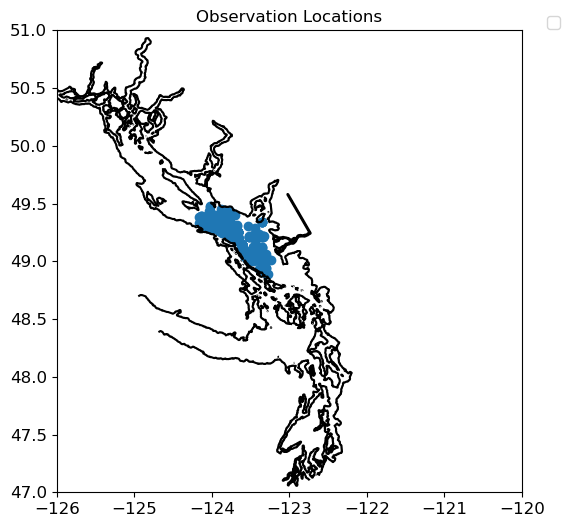

In [106]:
fig, ax = plt.subplots(1,1,figsize = (6,6))
with nc.Dataset('/ocean/ksuchy/MOAD/NEMO-forcing/grid/bathymetry_201702.nc') as grid:
    viz_tools.plot_coastline(ax, grid, coords = 'map',isobath=.1)
colors=('teal','green','firebrick','darkorange','darkviolet','fuchsia',
        'royalblue','darkgoldenrod','mediumspringgreen','deepskyblue','lightblue')
#datreg=dict()
#for ind, iregion in enumerate(data.region_name.unique()):
#    datreg[iregion] = data.loc[data.region_name==iregion]
ax.scatter(datazoo['Lon'], datazoo['Lat'],marker='o') #color = colors[ind]
ax.set_ylim(47,51)
ax.legend(bbox_to_anchor=[1,.6,0,0])
ax.set_xlim(-126, -120);
ax.set_title('Observation Locations');
ax.legend(bbox_to_anchor=(1.1, 1.05))

In [107]:

datazoo=datazoo.dropna(subset=['Total'])

In [108]:
obs_zoop=datazoo.groupby(['Lon','Lat','YMO','Year'])['Total'].mean().reset_index()

In [109]:
obs_zoop_std=datazoo.groupby(['Lon','Lat','YMO','Year'])['Total'].mean().reset_index()

In [110]:
obs_zoop_YMO=obs_zoop.groupby(['YMO','Year'])['Total'].mean().reset_index()

In [111]:
obs_zoop_YMO_std=obs_zoop.groupby(['YMO','Year'])['Total'].std().reset_index()

In [112]:
obs_zoop_YMO

,YMO,Year,Total
0,2007-02-01,2007,2.003528
1,2007-04-01,2007,7.772780
2,2007-05-01,2007,31.035132
3,2007-06-01,2007,13.584812
4,2007-09-01,2007,2.818357
...,...,...,...
111,2022-08-01,2022,15.572510
112,2022-09-01,2022,13.019941
113,2022-10-01,2022,5.206737
114,2022-11-01,2022,6.227817


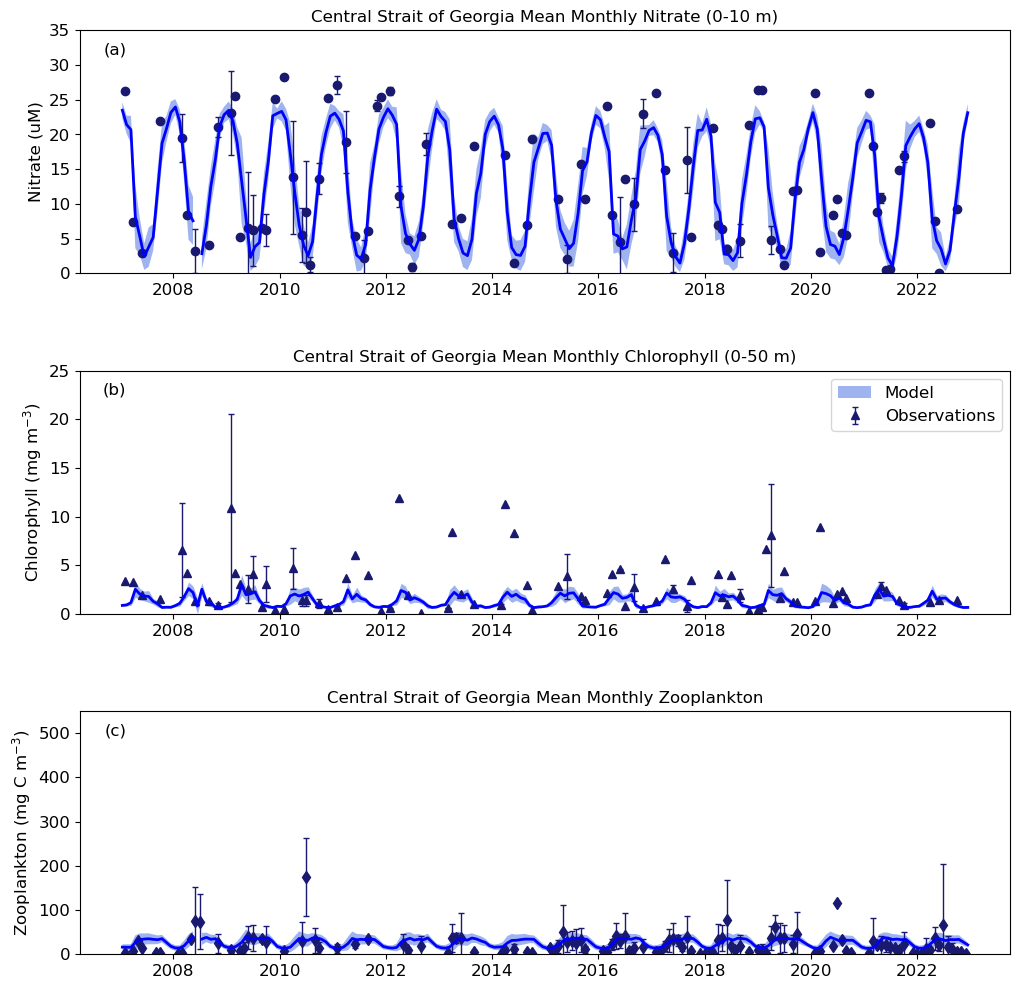

In [116]:
fig,ax=plt.subplots(3,1,figsize=(12,12))

fig.subplots_adjust(hspace=0.4)

#ax.scatter(obs_nitrate.index,obs_nitrate,marker='o',color='springgreen',edgecolor='k',s=20,label='Observations')
ax[0].errorbar(obs_nitrate_YMO.YMO,obs_nitrate_YMO['NO3 (uM)'],yerr=obs_nitrate_YMO_std['NO3 (uM)'],fmt='o',color='midnightblue',ecolor = 'midnightblue', elinewidth = 1, capsize = 2,label='Observations')
ax[0].set_ylim(0,35)
ax[0].set_title('Central Strait of Georgia Mean Monthly Nitrate (0-10 m)')
#ax.errorbar(tt,(mod_nitrate_mean-mod_nitrate_std)*1.8,(mod_nitrate_mean+mod_nitrate_std,)*1.8)

ax[0].errorbar(tt, mod_nitrate_mean_clean,label='',color='b',linestyle='-',linewidth=2)
ax[0].fill_between(tt, (mod_nitrate_mean_clean-mod_nitrate_std_new), (mod_nitrate_mean_clean+mod_nitrate_std_new),
    alpha=0.5, edgecolor='royalblue', facecolor='royalblue',
    linewidth=0,label='Model')
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)

ax[0].set_ylabel('Nitrate (uM)',fontsize=12)
#ax[0].legend(loc=4,frameon=True,fontsize=12)


#ax.scatter(obs_chl.index,obs_chl,marker='o',color='springgreen',edgecolor='k',s=20,label='Observations')
ax[1].errorbar(obs_chl_YMO.YMO,obs_chl_YMO['Chl (mg m-3)'],yerr=obs_chl_YMO_std['Chl (mg m-3)'],fmt='^',color='midnightblue',ecolor = 'midnightblue', elinewidth = 1, capsize = 2,label='Observations')
ax[1].set_ylim(0,25)
ax[1].set_title('Central Strait of Georgia Mean Monthly Chlorophyll (0-50 m)')
#ax.errorbar(tt,(mod_diatoms_mean-mod_diatoms_std)*1.8,(mod_diatoms_mean+mod_diatoms_std,)*1.8)

ax[1].errorbar(tt, mod_chl_mean,label='',color='b',linestyle='-',linewidth=2)
ax[1].fill_between(tt, (mod_chl_mean-mod_chl_std_new), (mod_chl_mean+mod_chl_std_new),
    alpha=0.5, edgecolor='royalblue', facecolor='royalblue',
    linewidth=0,label='Model')
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)

ax[1].set_ylabel('Chlorophyll (mg m$^{-3}$)',fontsize=12)
ax[1].legend(frameon=True,fontsize=12)


ax[2].errorbar(obs_zoop_YMO.YMO,obs_zoop_YMO.Total,yerr=obs_zoop_YMO_std.Total,fmt='d',color='midnightblue',ecolor = 'midnightblue', elinewidth = 1, capsize = 2,label='Observations')
ax[2].set_ylim(0,550)
ax[2].set_title('Central Strait of Georgia Mean Monthly Zooplankton')
#ax.errorbar(tt,(mod_microzooplankton_mean-mod_microzooplankton_std)*1.8,(mod_microzooplankton_mean+mod_microzooplankton_std,)*1.8)

ax[2].errorbar(tt, mod_zoop_mean_clean,label='',color='b',linestyle='-',linewidth=2)
ax[2].fill_between(tt, (mod_zoop_mean_clean-mod_zoop_std_new), (mod_zoop_mean_clean+mod_zoop_std_new),
    alpha=0.5, edgecolor='royalblue', facecolor='royalblue',
    linewidth=0,label='Model')

plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
ax[2].set_ylabel('Zooplankton (mg C m$^{-3}$)',fontsize=12)
#ax[2].legend(frameon=True,fontsize=12)

labels = ['a', 'b', 'c']
for i in range(3):
    ax[i].text(0.05, 0.95, f'({labels[i]})', transform=ax[i].transAxes,
               fontsize=12,  va='top', ha='right')
    
#plt.savefig('Figure10_CentralSoGModelvsObsTimeseries.png', bbox_inches='tight',dpi=1000,transparent=False)